# Reinforcement Learning - Temporal Difference
If you want to test/submit your solution **restart the kernel, run all cells and submit the td_autograde.py file into codegrade.**

In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Temporal Difference (TD) learning

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [4]:
import gym 
env = gym.make('FrozenLake-v1').env
#??env
env.reset()

for state in env.P:
    for action in env.P[state]:
        for i, transition in enumerate(env.P[state][action]):
            t2 = transition[2]
            if transition[3] and  transition[1] != 15:
                t2 = -1
            elif transition[1] != 15:
                t2 = 0
            if i == 1:
                env.P[state][action][i] = (0.8, transition[1], t2, transition[3])
            else:
                env.P[state][action][i] = (0.1, transition[1], t2, transition[3])

print()
print(env.P)
env.reset()
print(env.P)



{0: {0: [(0.1, 0, 0, False), (0.8, 0, 0, False), (0.1, 4, 0, False)], 1: [(0.1, 0, 0, False), (0.8, 4, 0, False), (0.1, 1, 0, False)], 2: [(0.1, 4, 0, False), (0.8, 1, 0, False), (0.1, 0, 0, False)], 3: [(0.1, 1, 0, False), (0.8, 0, 0, False), (0.1, 0, 0, False)]}, 1: {0: [(0.1, 1, 0, False), (0.8, 0, 0, False), (0.1, 5, -1, True)], 1: [(0.1, 0, 0, False), (0.8, 5, -1, True), (0.1, 2, 0, False)], 2: [(0.1, 5, -1, True), (0.8, 2, 0, False), (0.1, 1, 0, False)], 3: [(0.1, 2, 0, False), (0.8, 1, 0, False), (0.1, 0, 0, False)]}, 2: {0: [(0.1, 2, 0, False), (0.8, 1, 0, False), (0.1, 6, 0, False)], 1: [(0.1, 1, 0, False), (0.8, 6, 0, False), (0.1, 3, 0, False)], 2: [(0.1, 6, 0, False), (0.8, 3, 0, False), (0.1, 2, 0, False)], 3: [(0.1, 3, 0, False), (0.8, 2, 0, False), (0.1, 1, 0, False)]}, 3: {0: [(0.1, 3, 0, False), (0.8, 2, 0, False), (0.1, 7, -1, True)], 1: [(0.1, 2, 0, False), (0.8, 7, -1, True), (0.1, 3, 0, False)], 2: [(0.1, 7, -1, True), (0.8, 3, 0, False), (0.1, 3, 0, False)], 3: [

In [5]:
print(env.step(1))

(4, 0, False, {'prob': 0.8})


Implement the EpsilonGreedyPolicy class which uses Q-values to sample an action.

In [6]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(len(self.Q[0,:]))
        else:
            return np.random.choice(np.flatnonzero(self.Q[obs] == self.Q[obs].max()))

In [7]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

We can also learn the optimal (non-exploring) policy while using another policy to do exploration, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

In [25]:
def q_learning(env, policy, Q, num_episodes, discount_factor=0.99, alpha=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    for i_episode in range(num_episodes):
        i = 0 # episode length
        R = 0 # episode return
        state = env.reset()
        while True:
            i += 1 # update episode length
    
            a = policy.sample_action(state)
            (next_state, reward, done, _) = env.step(a)
            max_a = np.max(Q[next_state,:])
            Q[state][a] = Q[state][a] + alpha*(reward + discount_factor*max_a - Q[state][a])
            R += reward # update episode return
            
            state = next_state
            policy.Q = Q
            if done:
                break
                
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [26]:
def double_q_learning(env, policy, Q, num_episodes, discount_factor=0.99, alpha=0.1):
    # Keeps track of useful statistics
    stats = []
    Q1 = np.copy(Q)
    Q2 = np.copy(Q)
    for i_episode in range(num_episodes):
        i = 0 # episode length
        R = 0 # episode return
        
        state = env.reset()
        while True:
            i += 1 # update episode length
                
            a = policy.sample_action(state)
            (next_state, reward, done, _) = env.step(a)
            if np.random.choice([True, False]):
                argmax_a = np.argmax(Q1[next_state,:])
                Q1[state][a] = Q1[state][a] + alpha*(reward + discount_factor*Q2[next_state][argmax_a] - Q1[state][a])
                R += reward # update episode return
            else:
                argmax_a = np.argmax(Q2[next_state,:])
                Q2[state][a] = Q2[state][a] + alpha*(reward + discount_factor*Q1[next_state][argmax_a] - Q2[state][a])
                R += reward # update episode return
            
            state = next_state
            
            policy.Q = (Q1+Q2)/2
            if done:
                break
        
        Q = (Q1+Q2)/2
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

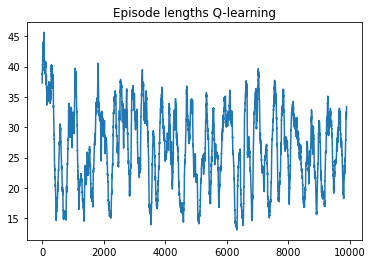

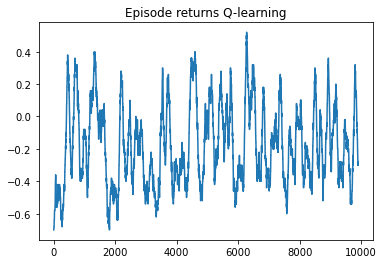

In [27]:
Q = np.zeros((env.nS, env.nA))
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 10000)

n = 100
# We will help you with plotting this time
plt.plot(running_mean(episode_lengths_q_learning,n))
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(running_mean(episode_returns_q_learning,n))
plt.title('Episode returns Q-learning')
plt.show()

[[ 0.43817212  0.34992927  0.10628323  0.29104768]
 [ 0.02801783 -0.76168282 -0.15779448  0.00910905]
 [ 0.19273432 -0.04338769 -0.30148785 -0.02280638]
 [-0.1355964  -0.62107704 -0.37967954 -0.39455948]
 [ 0.34442387  0.50908395 -0.7394659   0.17949304]
 [ 0.          0.          0.          0.        ]
 [-0.3913859   0.72323559 -0.46796282 -0.2379463 ]
 [ 0.          0.          0.          0.        ]
 [ 0.44458714 -0.67066257  0.69649283  0.37838319]
 [ 0.49759143  0.93977012  0.75929119 -0.80581957]
 [ 0.90548233  0.73470584 -0.43209926 -0.05972511]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.40010007  0.77395566  0.9687306   0.77584934]
 [ 0.94500694  0.96905823  0.97857315  0.88306739]
 [ 0.          0.          0.          0.        ]]


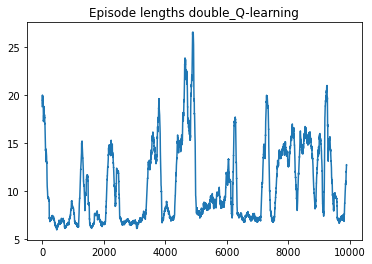

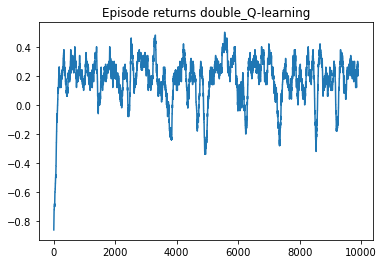

In [28]:
Q = np.zeros((env.nS, env.nA))
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, 10000)
print(policy.Q)
n = 100
# We will help you with plotting this time
plt.plot(running_mean(episode_lengths_double_q_learning,n))
plt.title('Episode lengths double_Q-learning')
plt.show()
plt.plot(running_mean(episode_returns_double_q_learning,n))
plt.title('Episode returns double_Q-learning')
plt.show()

# Comparing episode returns during training

You will now compare the episode returns while learning for Q-learning and Sarsa by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, we will smooth the returns (e.g. plot the $n$ episode average instead).

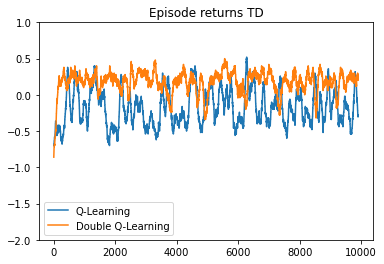

In [29]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

n = 100
plt.plot(running_mean(episode_returns_q_learning, n), label='Q-Learning')
plt.plot(running_mean(episode_returns_double_q_learning, n), label='Double Q-Learning')
plt.title('Episode returns TD')
# plt.legend(['Q-Learning', 'Double Q-learning', 'Sarsa'])
plt.legend()
plt.gca().set_ylim([-2, 1])
plt.show()

100%|█████████████████████████████████████████| 500/500 [00:55<00:00,  9.09it/s]


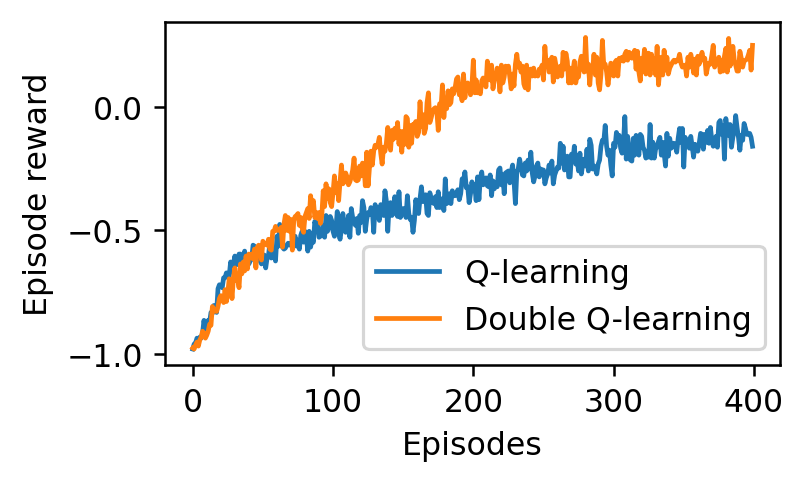

In [33]:
def mean_multiple_runs_both_algorithms(n_runs = 500, n_episodes = 400):
    single_results = np.zeros((n_runs, n_episodes))
    np.random.seed(42)
    for i in tqdm(range(n_runs)):
        Q = np.zeros((env.nS, env.nA))
        policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
        Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, n_episodes)
        single_results[i] = episode_returns_q_learning        
    double_results = np.zeros((n_runs, n_episodes))
    for i in tqdm(range(n_runs)):
        Q = np.zeros((env.nS, env.nA))
        policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
        Q_q_learning, (episode_lengths_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, n_episodes)
        double_results[i] = episode_returns_double_q_learning
    single_sorted = np.sort(single_results, axis=0)
    double_sorted = np.sort(double_results, axis=0)
    single_bottom = single_sorted[int(0.025*n_runs)]
    single_top = single_sorted[int(0.975*n_runs)]
    double_bottom = double_sorted[int(0.025*n_runs)]
    double_top = double_sorted[int(0.975*n_runs)]
    return np.mean(single_results, axis=0), np.mean(double_results, axis=0), single_bottom, single_top, double_bottom, double_top

def plot_both(mean_single, mean_double, single_bottom, single_top, double_bottom, double_top):
    plt.figure(figsize=[3.5,2],dpi=227)

#     plt.axhline(y=95, color='tab:cyan', linestyle='--', label='Optimal')
    plt.plot(mean_single, label='Q-learning')
    plt.plot(mean_double, label='Double Q-learning')
#     plt.fill_between(np.arange(len(mean_single)), single_bottom, single_top, alpha=0.5)
#     plt.fill_between(np.arange(len(mean_double)), double_bottom, double_top, alpha=0.5)
    plt.xlabel('Episodes')
    plt.ylabel('Episode reward')
    plt.legend()
    plt.show()
        
plot_both(*mean_multiple_runs_both_algorithms(n_runs=500))